In [1]:
import numpy as np
import AuxFunctions as aux
import main as main
import timeit

In [2]:
# Define the parameters of the system
N = 216 #Number of seeds
box = [-3, -3, 0, 3, 3, 1] #list or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 #Percent tolerance
tf = 1 #Final time
Ndt = 100 #Number of timesteps

#Initialize initial condition
Z = aux.create_initial(N, 4, 4, 4, -4, -4, 0, 'lattice wsp') #Initial guess that is uniform in x any y and sin(uniform) in z

In [3]:
#start = timeit.default_timer()
main.SGSolver(box, Z, N, per_tol, tf, Ndt) #Solve and save the solution
#end = timeit.default_timer()
#print(abs(end - start))

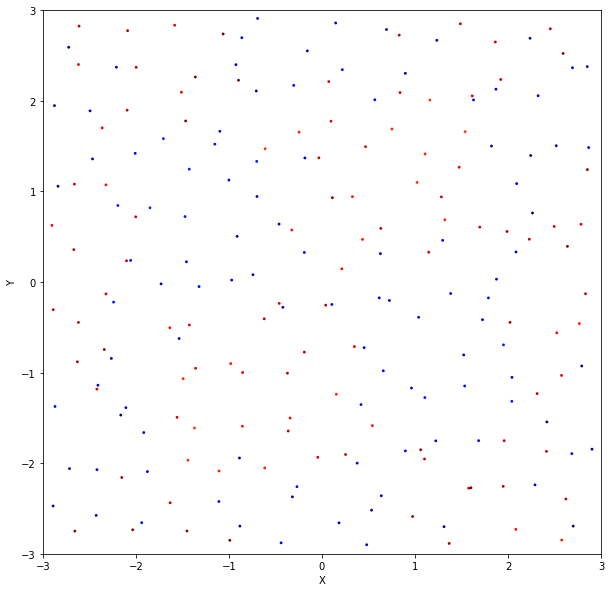

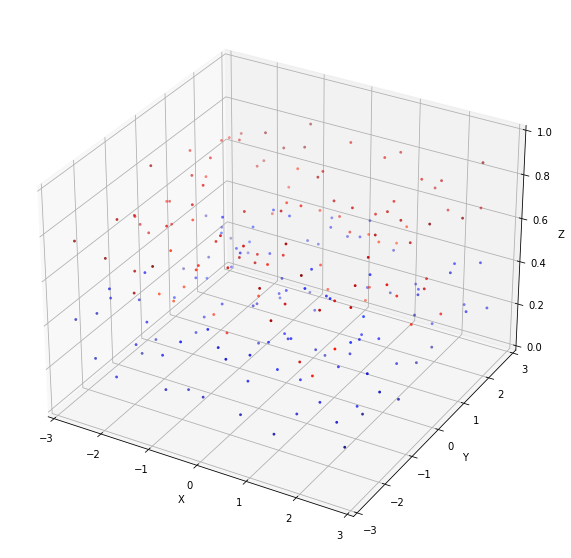

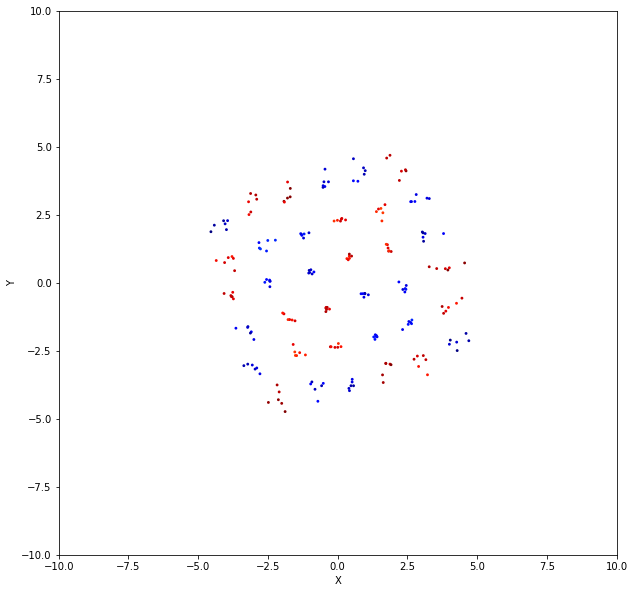

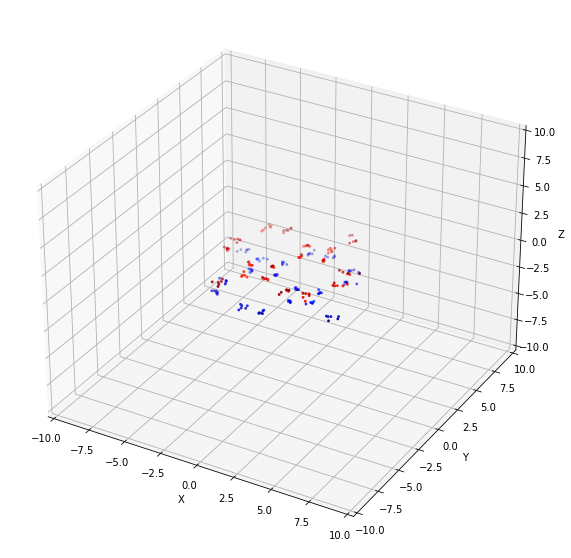

In [4]:
aux.animator('./SG_data.npz', 'C', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
aux.animator('./SG_data.npz', 'C', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
aux.animator('./SG_data.npz', 'Z', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
aux.animator('./SG_data.npz', 'Z', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(10, 10, True)
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=0)

plt.show()

In [ ]:
from pysdot import OptimalTransport
from pysdot import PowerDiagram

Num = [8, 27, 64, 125, 216, 343, 512, 729, 1000, 1331, 1728, 2197, 2744, 3375]
box = [-3, -3, -3, 3, 3, 3]
D = aux.make_domain(box)

for i in Num:
    Z = aux.create_initial(i, 1, 1, 1, 0, 0, 0, 'lattice') #Initial guess that is uniform in x any y and sin(uniform) in z
    w0 = aux.Rescale_weights(box, Z)[0]
    ot = OptimalTransport(positions = Z, weights = w0, masses = D.measure() / i * np.ones(i), domain = D, linear_solver= 'Petsc')
    start = timeit.default_timer()
    #pd = PowerDiagram(positions=Z,weights=w0,domain=D)
    ot.adjust_weights()
    end = timeit.default_timer()
    print(i, abs(end - start))
